# Single-cell example

In this notebook, we show how to initialize a FLeCS model based on a single-cell Scanpy object, load trained weights and generate the predicted dynamics and plot the GRN with learned regulation strengths.

For training, please check the script available in `figure2/train_gene.py`

In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPop
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad
import seaborn as sns
import networkx as nx

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (9,5)

## Load single-cell data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "figure2", "processed", "adata_processed_with_paths_magic.h5ad")
                     )

In [3]:
adata

AnnData object with n_obs × n_vars = 7296 × 4000
    obs: 'index', 'Seq_batch_ID', 'Amp_batch_ID', 'well_coordinates', 'Mouse_ID', 'Plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'RMT_sequence', 'Number_of_cells', 'CD34_measurement', 'FcgR3_measurement', 'n_counts_all', 'n_counts'
    var: 'n_counts', 'highly_variable'
    uns: 'cebpa_ko_shortest_paths', 'cebpe_ko_shortest_paths', 'neighbors', 'pca', 'umap', 'unsorted_shortest_paths'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
    varp: 'grn_adj_mat'

This is a Scanpy adata object with a GRN adjacency matrix stored in `adata.varp['grn_adj_mat']`.

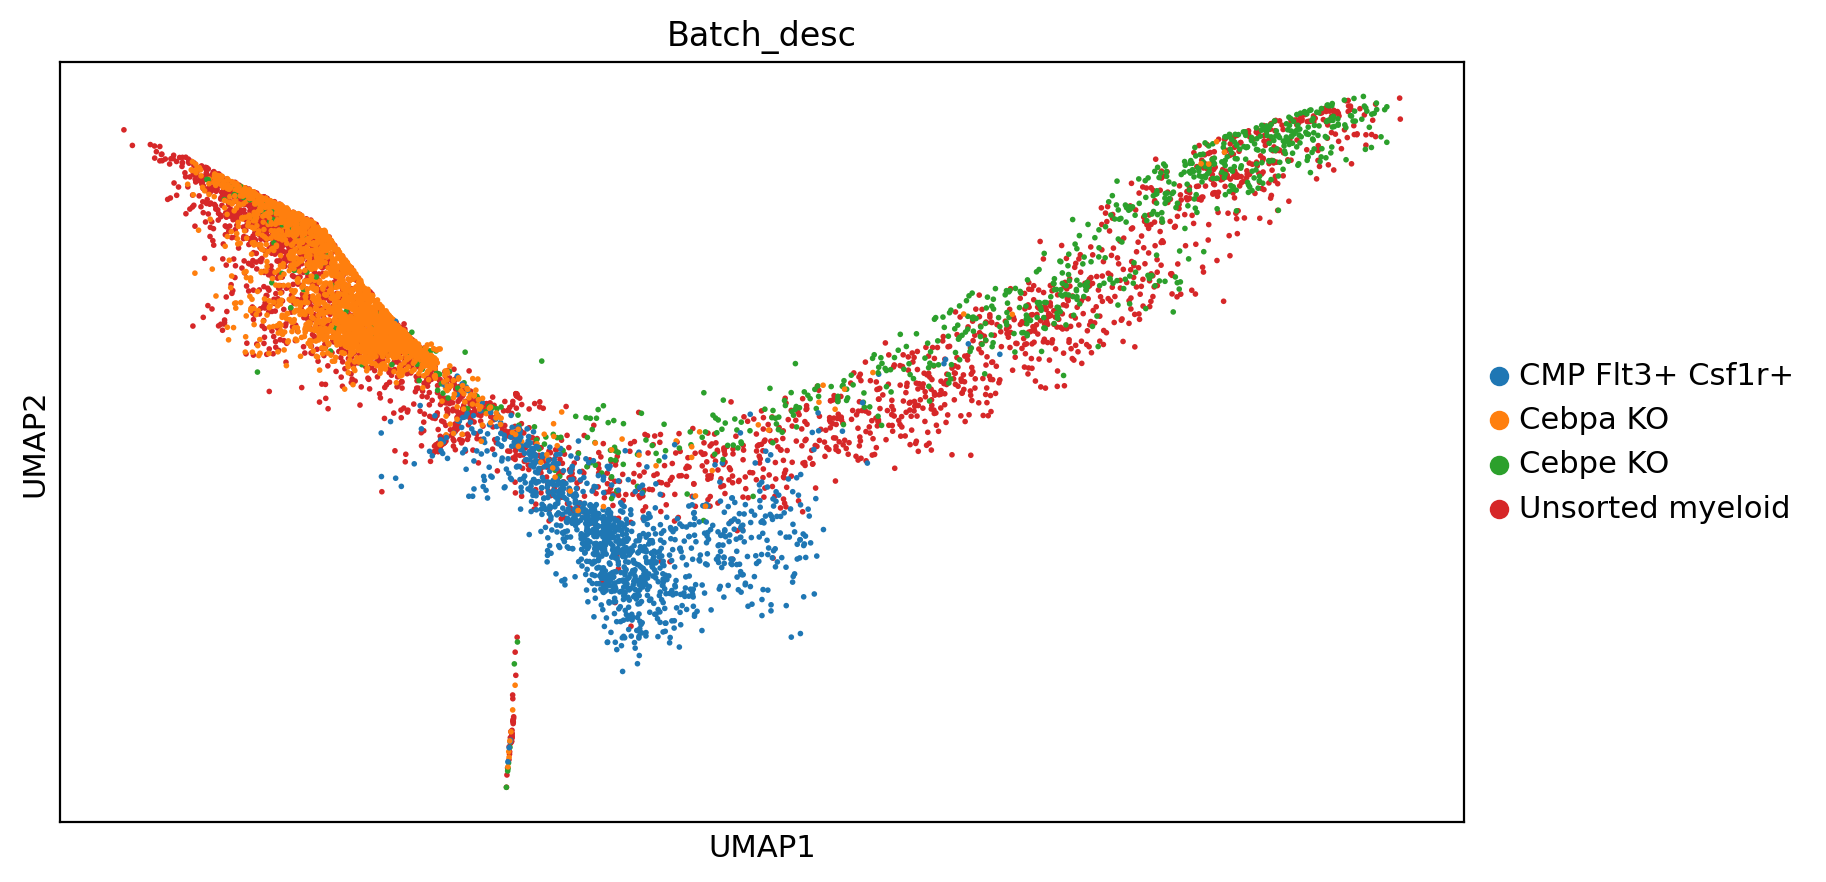

In [4]:
sc.pl.umap(adata, color="Batch_desc")

In [5]:
cmp_cells = list(adata.obs[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].index.astype("int"))
unsorted_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Unsorted myeloid'].index.astype("int"))
cebpa_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpa KO'].index.astype("int"))
cebpe_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpe KO'].index.astype("int"))
cmp_unsorted_adata = adata[cmp_cells + unsorted_cells]

## Model

In [6]:
batch_size = cmp_unsorted_adata.shape[0]
n_latent = 0

In [7]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

## Load weights

In [8]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                             "trained_mycellpop_24_jul_19_2.pt"), 
                                map_location=torch.device('cpu'))

In [9]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

## Predict dynamics

In [10]:
with torch.no_grad():
    gene_expr = torch.Tensor(cmp_unsorted_adata.X[:, :, None])
    velocities = mycellpop.get_derivatives(gene_expr)
        
velocities = velocities.cpu().numpy()[:, :, 0]

# Add infered velocities to adata object for later plotting
cmp_unsorted_adata.layers["velocity"] = velocities
cmp_unsorted_adata.layers["X"] = cmp_unsorted_adata.X

## Plot dynamics

In [11]:
sc.pp.neighbors(cmp_unsorted_adata, n_neighbors=30, n_pcs=50)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
scv.tl.velocity_graph(cmp_unsorted_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/64 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:18) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


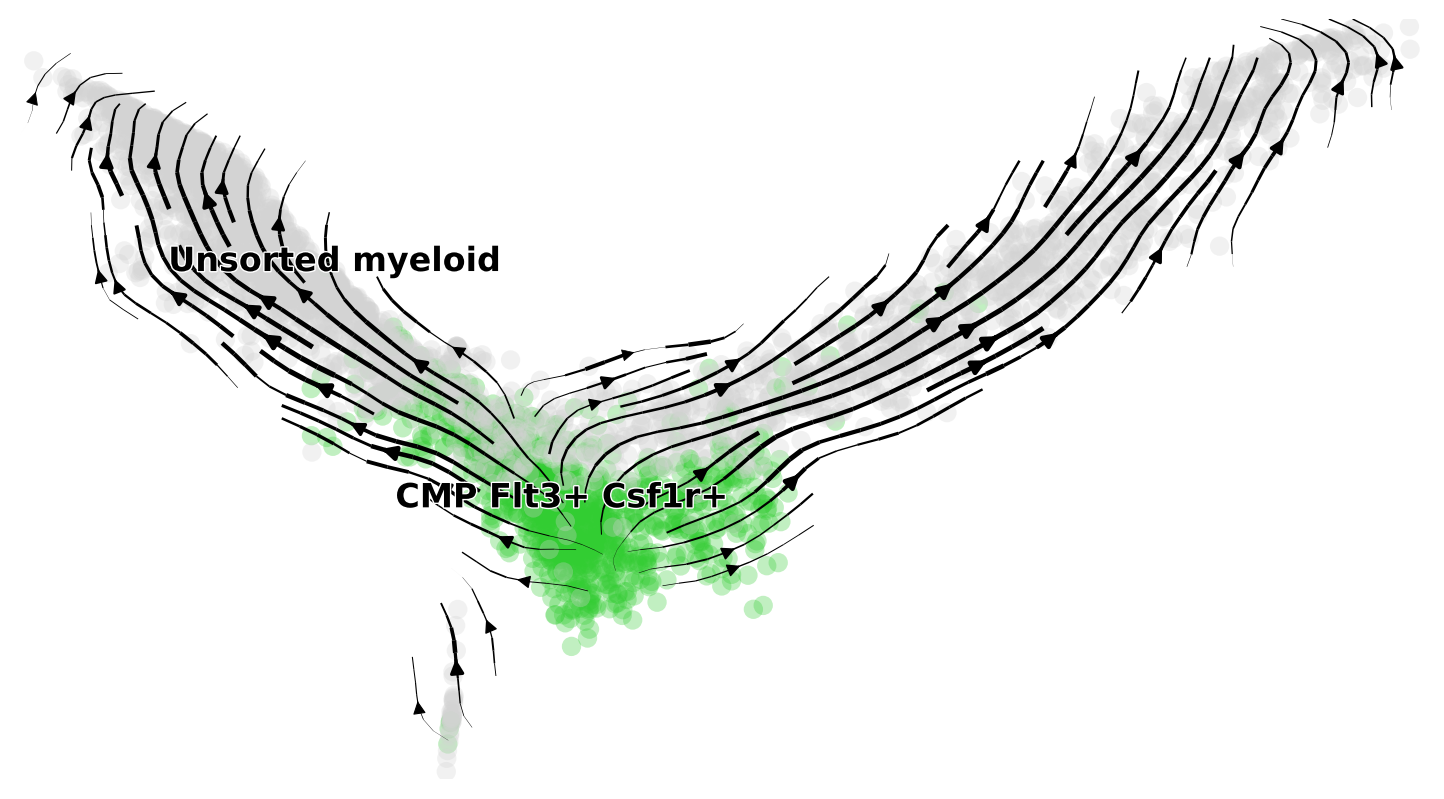

In [13]:
plt.rcParams["figure.figsize"] = (9,5)
scv.pl.velocity_embedding_stream(cmp_unsorted_adata, basis='umap', color="Batch_desc", layer="obs", palette=["limegreen", "lightgrey"], title="")

## GRN with learned interaction strengths

As the learned GRN with interaction strength is huge, we only show a random subgraph over 50 genes.

In [14]:
graph_edges = mycellpop["gene", "regulates", "gene"].edges.numpy().tolist()
interaction_strengths = mycellpop["gene", "regulates", "gene"].simple_conv_weights.data

We build a networkx object for plotting

In [15]:
nx_graph_edges = [e + [{"strength": interaction_strengths[0, i].item()}] for i, e in enumerate(graph_edges)]
g = nx.DiGraph()
g.add_nodes_from(range(4000))
g.add_edges_from(nx_graph_edges)
nx.set_node_attributes(g, {i: mycellpop["gene"].name[i] for i in range(4000)}, name="name")

We select a random subgraph and we plot

In [16]:
np.random.seed(6)
sub_g = g.subgraph(np.random.randint(4000, size=50))

In [17]:
pos=nx.spring_layout(sub_g, k=2.5)

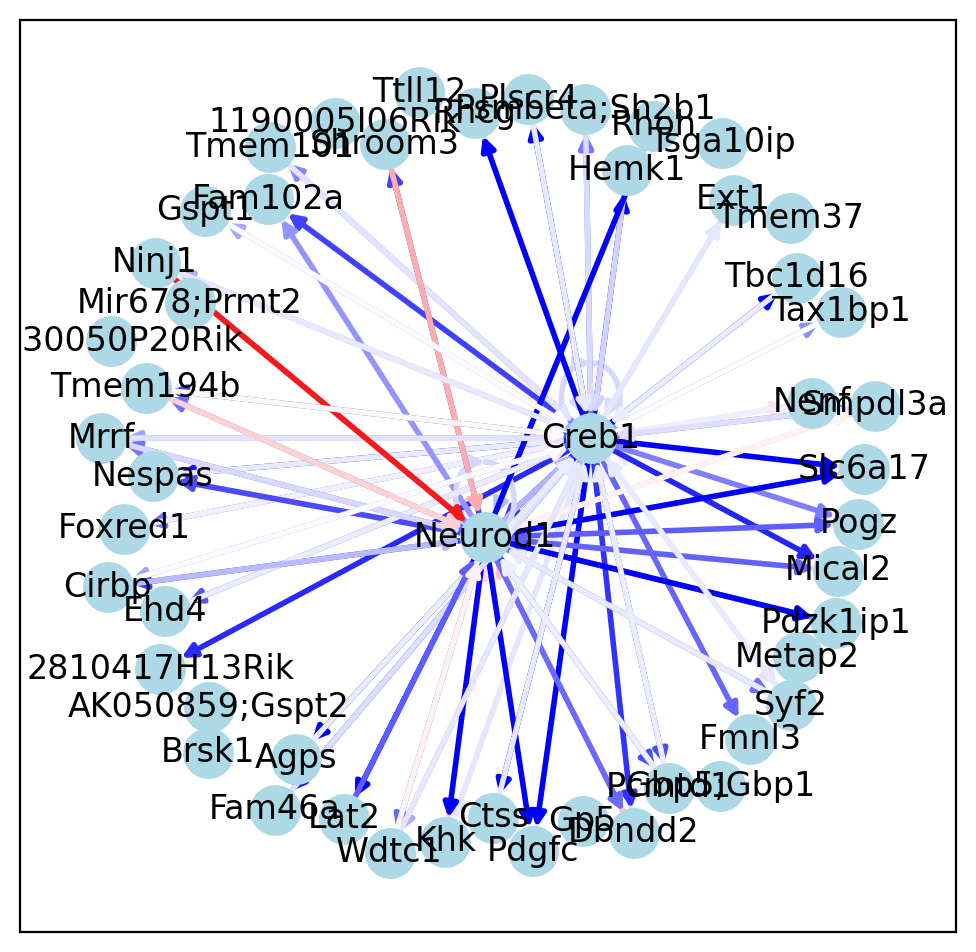

In [18]:
plt.rcParams["figure.figsize"] = (6, 6)
nx.draw_networkx(sub_g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(sub_g,'strength').values()),
        edge_cmap= plt.get_cmap('bwr'),
        with_labels = True,
        labels=nx.get_node_attributes(sub_g, "name"),
        edge_vmin=-0.3, edge_vmax=0.3,
        width=2)

plt.show()

## Cebpa KO condition

We adapt the model to the Cebpa KO condition.

In [19]:
cmp_cebpa_ko_adata = adata[cmp_cells + cebpa_cells]
batch_size = cmp_cebpa_ko_adata.shape[0]

In [20]:
# Remove outgoing edges of Cebpa
cebpa_idx = mycellpop["gene"].name.index('Cebpa')
outgoing_cebpa_edges = (mycellpop['gene', 'regulates', 'gene'].edges[:, 0] == cebpa_idx)
mycellpop['gene', 'regulates', 'gene'].remove_edges(outgoing_cebpa_edges)

In [21]:
mycellpop.change_batch_size(batch_size)

We load the trained weights for the Cepba KO condition

In [26]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                             "trained_mycellpop_24_aug_5_1.pt"), 
                                map_location=torch.device('cpu'))

In [27]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

We predict velocities

In [28]:
with torch.no_grad():
    gene_expr = torch.Tensor(cmp_cebpa_ko_adata.X[:, :, None])
    velocities = mycellpop.get_derivatives(gene_expr)
        
velocities = velocities.cpu().numpy()[:, :, 0]
cmp_cebpa_ko_adata.layers["velocity"] = velocities
cmp_cebpa_ko_adata.layers["X"] = cmp_cebpa_ko_adata.X

We plot velocities

In [29]:
sc.pp.neighbors(cmp_cebpa_ko_adata, n_neighbors=30, n_pcs=50)

In [30]:
scv.tl.velocity_graph(cmp_cebpa_ko_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/64 cores)


  0%|          | 0/3456 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


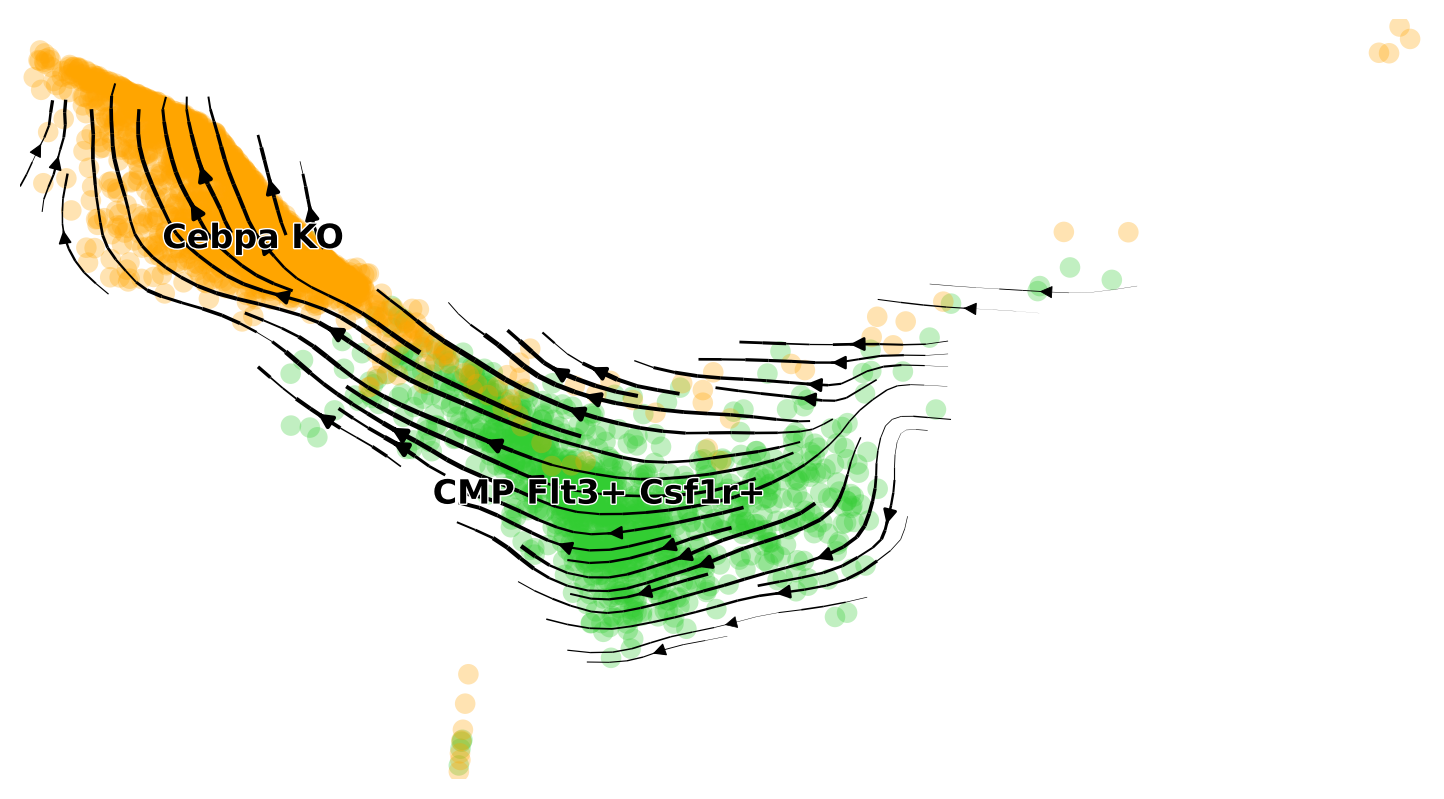

In [32]:
plt.rcParams["figure.figsize"] = (9, 5)
scv.pl.velocity_embedding_stream(cmp_cebpa_ko_adata, basis='umap', color="Batch_desc", layer="obs", palette=["limegreen", "orange"], title="")